<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers

In [80]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [81]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Перемешаем тренировочные данные
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [82]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [83]:
model = tf.keras.Sequential()

model.add(layers.Flatten(input_shape=(28, 28)))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.2))

# model.add(layers.Dense(216, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# # model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dropout(0.5))
# # model.add(layers.Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10, activation='softmax'))
# model.add(layers.Softmax())

In [84]:
model.compile(#optimizer='adam',
              optimizer='adamax',
              # optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [85]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(x_train, y_train,
                    epochs=60,
                    batch_size=128,
                    validation_data=(x_val, y_val))
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/60
391/391 [==============================] - 10s 25ms/step - loss: 0.6692 - sparse_categorical_accuracy: 0.7611 - val_loss: 0.4483 - val_sparse_categorical_accuracy: 0.8372
Epoch 2/60
391/391 [==============================] - 8s 20ms/step - loss: 0.4567 - sparse_categorical_accuracy: 0.8351 - val_loss: 0.3933 - val_sparse_categorical_accuracy: 0.8581
Epoch 3/60
391/391 [==============================] - 9s 24ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.8503 - val_loss: 0.3697 - val_sparse_categorical_accuracy: 0.8631
Epoch 4/60
391/391 [==============================] - 9s 24ms/step - loss: 0.3814 - sparse_categorical_accuracy: 0.8611 - val_loss: 0.3552 - val_sparse_categorical_accuracy: 0.8746
Epoch 5/60
391/391 [==============================] - 8s 20ms/step - loss: 0.3631 - sparse_categorical_accuracy: 0.8666 - val_loss: 0.3501 - val_sparse_categorical_accuracy: 0.8750
Epoch 6/60
391/391 [==============================] - 9s 24ms/step - loss: 0.3465 - sparse_cat

In [86]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


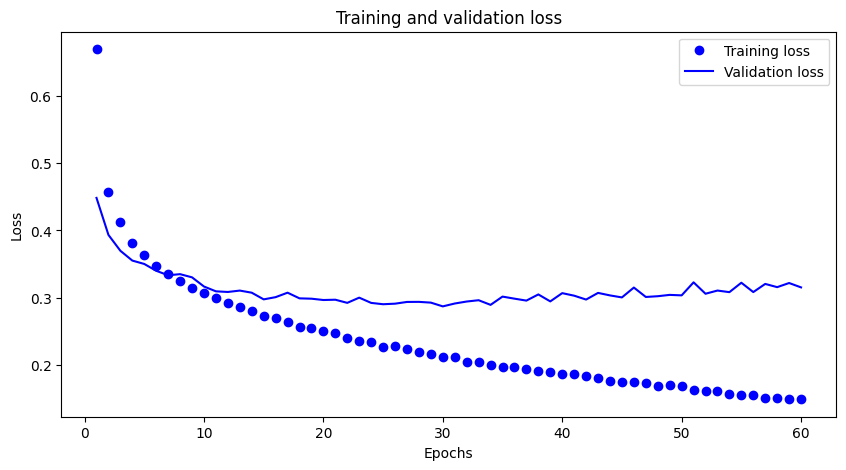

<Figure size 640x480 with 0 Axes>

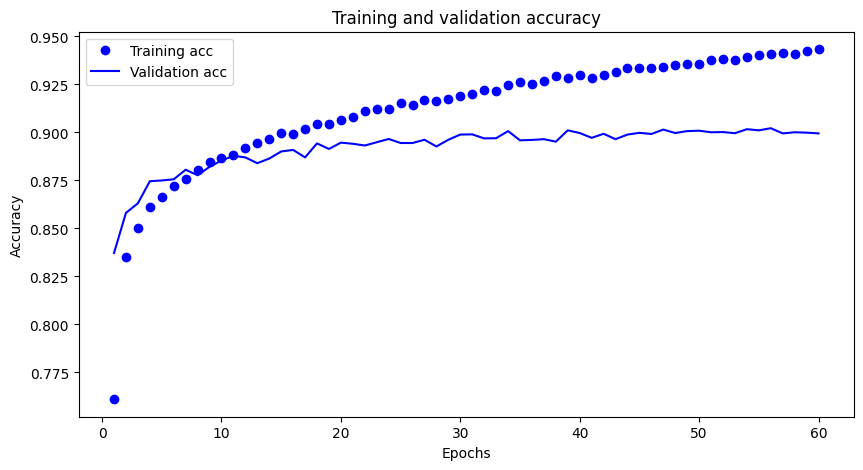

In [87]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [88]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [89]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [90]:
predictions[0]

array([0.08533724, 0.08533729, 0.08533724, 0.08533724, 0.08533724,
       0.08533783, 0.08533724, 0.08534002, 0.08533725, 0.23196141],
      dtype=float32)

In [91]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               401920    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               65664     
                                                                 
 dense_24 (Dense)            (None, 10)              